#### Back to [Zachary's Portfolio](https://zraup.github.io/Zachary-Raup/)

---

# Discovering Similar Songs Using Machine Learning | Unsupervised Learning with Spotify Data

### Introduction
In this project, build a content-based song similarity engine using Spotify audio features and machine learning. We apply Non-negative Matrix Factorization (NMF) to uncover hidden musical patterns, and compute cosine similarity to recommend tracks that sound alike. This type of recommender system has practical applications in music streaming, entertainment, and even broader fields like e-commerce where content-based filtering is used.


### Data Overview
The dataset is sourced from a public Kaggle dataset that includes Spotify's audio features and metadata for more than 6000 songs.

**Key features:**

- **Audio features:** danceability, energy, speechiness, acousticness, instrumentalness, liveness, valence

- **Quantitative metrics:** loudness, tempo, duration_ms

- **Popularity indicators:** weeks_on_chart, streams

- **Metadata:** artist_names, track_name

###  Skills Used
- **Exploratory Data Analysis (EDA):** Distribution plots, heatmaps, statistical summaries using *matplotlib* and *seaborn*

- **Feature Engineering:**

- **Power Transformation** to reduce skew

- **Feature Scaling:** Normalization with MinMaxScaler

- **Dimensionality Reduction:** NMF to identify latent features

- **Similarity Computation:** cosine_similarity for content-based recommendations

- **Unsupervised Learning:** NMF and t-SNE for visualization

- **Visualization:** Histograms, correlation heatmaps, scatter plots

- **Python Libraries:** *pandas, numpy, scikit-learn, matplotlib, seaborn, plotly*

### Reference Song Selection
Choose a reference track and specify the number of similar songs you'd like to retrieve. These recommendations will be based on audio feature similarity.
> Note: Ensure the song exists in the dataset with the correct formatting (e.g., "Track Name - Artist Name")

In [1]:
# Pick Reference Song
song_name = "Blinding Lights - The Weekend"

# Pick Number of Similar Songs to be Recommended
top_n = 10 # Number of similar songs in table

### Library Imports
Import all required Python libraries for data processing, analysis, and visualization.

In [2]:
!pip install -q kaleido

# Imports

# Core libraries
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Machine Learning and preprocessing
from sklearn.preprocessing import PowerTransformer, MinMaxScaler, Normalizer
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline

# Misc
import warnings
from IPython.display import Image, display

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 18.7 MB/s eta 0:00:00


### Load and Preview the Dataset
Load the dataset containing Spotify audio features and metadata, then inspect the first few entries to get an initial understanding of the data structure.

In [3]:
# Load and Explore Dataset
# This section loads the dataset
df_spotify = pd.read_csv('/kaggle/input/spotify-top-songs-and-audio-features/spotify_top_songs_audio_features.csv')
df_spotify.head()

,id,artist_names,track_name,source,key,mode,time_signature,danceability,energy,speechiness,acousticness,instrumentalness,liveness,valence,loudness,tempo,duration_ms,weeks_on_chart,streams
0,000xQL6tZNLJzIrtIgxqSl,"ZAYN, PARTYNEXTDOOR",Still Got Time (feat. PARTYNEXTDOOR),RCA Records Label,G,Major,4 beats,0.748,0.627,0.0639,0.13100,0.0,0.0852,0.524,-6.029,120.963,188491,17,107527761
1,003eoIwxETJujVWmNFMoZy,Alessia Cara,Growing Pains,Def Jam Recordings,C#/Db,Minor,4 beats,0.353,0.755,0.7330,0.08220,0.0,0.3900,0.437,-6.276,191.153,193680,2,9944865
2,003vvx7Niy0yvhvHt4a68B,The Killers,Mr. Brightside,Island Records,C#/Db,Major,4 beats,0.352,0.911,0.0747,0.00121,0.0,0.0995,0.236,-5.230,148.033,222973,125,512388123
3,00B7TZ0Xawar6NZ00JFomN,"Cardi B, Chance the Rapper",Best Life (feat. Chance The Rapper),Atlantic/KSR,A,Major,4 beats,0.620,0.625,0.5530,0.28700,0.0,0.3140,0.665,-7.438,167.911,284856,2,11985346
4,00Blm7zeNqgYLPtW6zg8cj,"Post Malone, The Weeknd",One Right Now (with The Weeknd),Republic Records,C#/Db,Major,4 beats,0.687,0.781,0.0530,0.03610,0.0,0.0755,0.688,-4.806,97.014,193507,30,301860377


### Data Cleaning
Clean the dataset to ensure consistency and reliability before analysis.

In [4]:
# Drop duplicate tracks by id
df_spotify.drop_duplicates(subset='id', inplace=True)

# Standardize artist name (e.g., fix variations in spelling)
df_spotify['artist_names'] = df_spotify['artist_names'].str.replace(r'\bThe Weeknd\b', 'The Weekend', regex=True)
df_spotify['track_name'] = df_spotify['track_name'].str.replace(r'\bThe Weeknd\b', 'The Weekend', regex=True)

# Drop missing values
df_spotify.dropna(inplace=True)

# Check for missing values
print("Missing values per column:\n", df_spotify.isnull().sum())

Missing values per column:
 id                  0
artist_names        0
track_name          0
source              0
key                 0
mode                0
time_signature      0
danceability        0
energy              0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
loudness            0
tempo               0
duration_ms         0
weeks_on_chart      0
streams             0
dtype: int64


### Dataset Summary
Review the dataset structure, data types, and statistical properties of numeric features.

In [5]:
# Display dataset structure and column data types
print(df_spotify.info())

# Display statistical summary of numeric columns
print(df_spotify.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6513 entries, 0 to 6512
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                6513 non-null   object 
 1   artist_names      6513 non-null   object 
 2   track_name        6513 non-null   object 
 3   source            6513 non-null   object 
 4   key               6513 non-null   object 
 5   mode              6513 non-null   object 
 6   time_signature    6513 non-null   object 
 7   danceability      6513 non-null   float64
 8   energy            6513 non-null   float64
 9   speechiness       6513 non-null   float64
 10  acousticness      6513 non-null   float64
 11  instrumentalness  6513 non-null   float64
 12  liveness          6513 non-null   float64
 13  valence           6513 non-null   float64
 14  loudness          6513 non-null   float64
 15  tempo             6513 non-null   float64
 16  duration_ms       6513 non-null   int64  


### Data Preprocessing & Normalization
To prepare for modeling, select relevant audio features and normalize them to reduce skewness and bring them onto a common scale.

- **Selected Features**: Core audio characteristics used for similarity computation

- **Normalization**: Apply PowerTransformer to reduce skewness and stabilize variance

In [6]:
# Select relevant audio features
audio_features = ['danceability', 'energy', 'acousticness',
                  'liveness', 'valence', 'tempo', 'loudness', 'speechiness']

# Apply PowerTransformer to normalize skewed features
pt = PowerTransformer()
df_spotify[audio_features] = pt.fit_transform(df_spotify[audio_features])

### Exploratory Data Analysis (EDA): Feature Distributions

Visualize the distribution of audio features after normalization. This helps assess whether transformations successfully reduced skewness and brought features to a comparable scale.

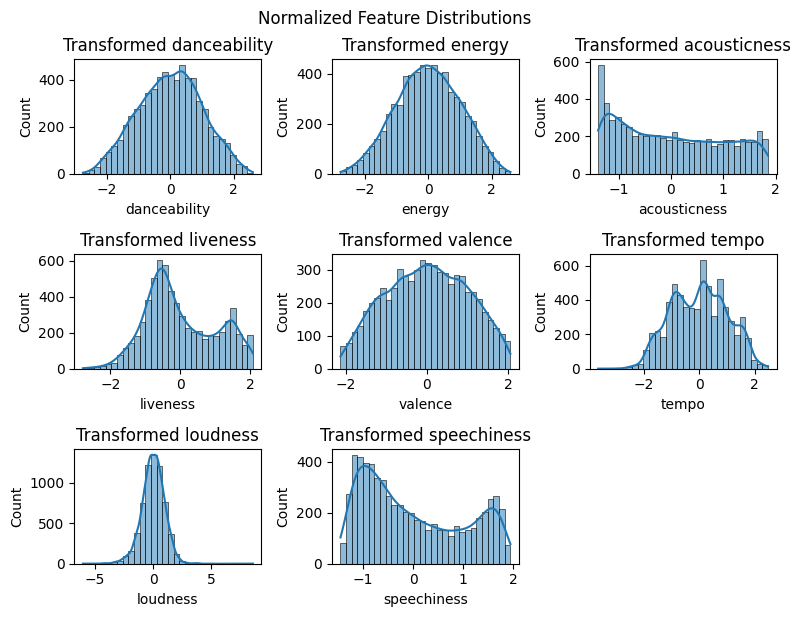

In [7]:
# Visualize distributions after transformation
plt.figure(figsize=(8, 6))
for i, col in enumerate(audio_features):
    plt.subplot(3, 3, i+1)
    sns.histplot(df_spotify[col], kde=True, bins=30)
    plt.title(f"Transformed {col}")
plt.tight_layout()
plt.suptitle("Normalized Feature Distributions", y=1.02)
plt.show()

#### Analysis of Normalized Distributions

The histograms above display the distribution of audio features after applying a PowerTransformer. Most features now resemble a more symmetric or Gaussian-like distribution, which is beneficial for distance-based methods such as cosine similarity.

- **Features like `danceability`, `energy`, and `valence`** exhibit near-normal distributions post-transformation.
- **Skewed features such as `acousticness`, `speechiness`, and `liveness`** retain some asymmetry, though the transformations have moderated extreme values.
- **`Loudness` and `tempo`** show clear multi-modal behavior, which may correspond to genre- or production-based clustering in the dataset.

### Correlation Heatmap

Display the pairwise correlation between audio features to understand interdependencies and potential redundancies in the dataset.

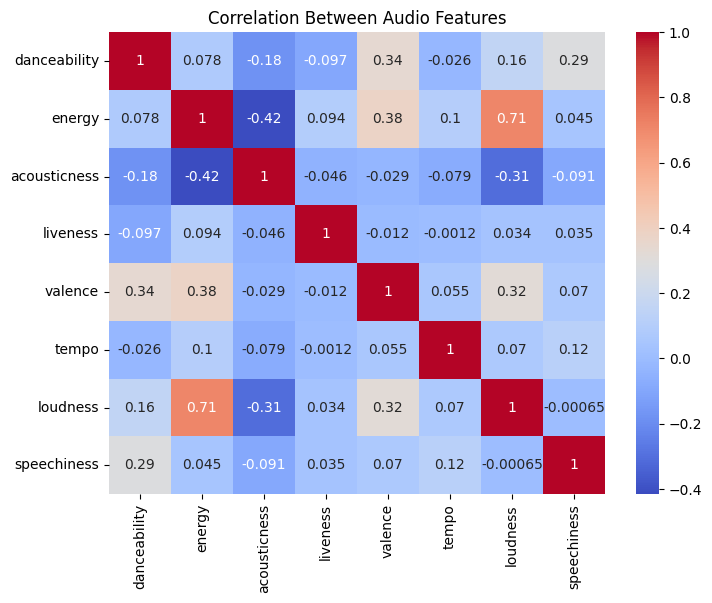

In [8]:
# Correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df_spotify[audio_features].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Between Audio Features")
plt.show()

#### Heatmap Interpretation

- **Energy** and **loudness** show a strong positive correlation *(r = 0.71)*, indicating that louder tracks tend to be perceived as more energetic.
- **Valence** and **energy** are moderately correlated *(r = 0.38)*, suggesting a loose association between high energy and a more positive mood.
- **Acousticness** is negatively correlated with **energy** *(r = -0.42)*, reflecting that more acoustic tracks are typically less energetic.

### Feature Scaling for NMF

Normalize feature values to the [0, 1] range using `MinMaxScaler`, as required by Non-negative Matrix Factorization (NMF), which assumes non-negative input data.

In [9]:
# Scale features to the [0, 1] range
scaler_mini = MinMaxScaler() 
X_scaled = scaler_mini.fit_transform(df_spotify[audio_features])

### Apply NMF for Latent Feature Extraction

Apply Non-negative Matrix Factorization (NMF) to reduce dimensionality and extract latent components that capture underlying patterns in the audio features.

In [10]:
# Apply NMF with 8 components to extract latent features
nmf = NMF(n_components=8, init='nndsvda', random_state=42, max_iter=2500)
X_nmf = nmf.fit_transform(X_scaled)

### Store Transformed Features as DataFrame

Convert the NMF-transformed matrix into a pandas DataFrame for easier indexing and downstream analysis.

In [11]:
# Store the transformed features as a DataFrame
df_nmf = pd.DataFrame(X_nmf, index=df_spotify.index)

### Song Similarity Engine

Use **cosine similarity** to recommend the top `n` most similar songs to a selected track, based on their latent audio features extracted by NMF.

Cosine similarity measures the **angle between two vectors** in multidimensional space — smaller angles indicate greater similarity. Since NMF projects songs into a feature space representing musical characteristics, this approach captures nuanced similarities in style, mood, and energy.

- A **small angle** indicates high similarity.
- A **larger angle** indicates lower similarity.

This technique is particularly well-suited for music recommendation systems where the "vibe" of the track is more important than any single raw feature value.

In [12]:
# Combine with track and artist names
df_spotify['track'] = df_spotify['track_name'] + " - " + df_spotify['artist_names']
df_nmf['track'] = df_spotify['track'].values

# Build Recommend Songs Function
def recommend_similar_songs(song_name, df):
    if song_name not in df['track'].values:
        return f"Song '{song_name}' not found."

    vectors = df.drop(columns=['track'])
    target_vector = vectors[df['track'] == song_name].values
    similarities = cosine_similarity(target_vector, vectors)[0]

    # Create full similarity DataFrame
    df_sim = df.copy()
    df_sim['similarity'] = similarities
    df_sim[['song_title', 'artist']] = df_sim['track'].str.split(' - ', n=1, expand=True)

    # Get top N similar songs (excluding the reference song)
    top_similar_songs = df_sim[df_sim['track'] != song_name].sort_values(by='similarity', ascending=False).drop_duplicates(['song_title', 'artist']).head(top_n)

    return df_sim, top_similar_songs

### Get Top 10 Similar Songs

Retrieve and display the top recommended songs based on similarity to the selected reference track.

In [13]:
# Compute similarity and retrieve recommendations
df_sim, top_similar_songs = recommend_similar_songs(song_name, df_nmf)

# Display top 10 similar songs with clean formatting
print("🎵 Top 10 Similar Songs to:", song_name)
for idx, row in top_similar_songs.iterrows():
    print(f"{row['song_title']} — {row['artist']} (Similarity: {row['similarity']:.4f})")

🎵 Top 10 Similar Songs to: Blinding Lights - The Weekend
Blinding Lights (with ROSALÍA) — Remix - The Weekend, ROSALÍA (Similarity: 0.9988)
I am not a woman, I'm a god — Halsey (Similarity: 0.9971)
Feels Great (feat. Fetty Wap & CVBZ) — Cheat Codes, Fetty Wap, CVBZ (Similarity: 0.9951)
Enough Is Enough — Post Malone (Similarity: 0.9939)
MI FAI IMPAZZIRE — BLANCO, Sfera Ebbasta (Similarity: 0.9936)
Last Day Alive — The Chainsmokers, Florida Georgia Line (Similarity: 0.9933)
POP/STARS — K/DA, Madison Beer, (G)I-DLE, Jaira Burns, League of Legends (Similarity: 0.9931)
Love It If We Made It — The 1975 (Similarity: 0.9929)
When I’m Alone — Post Malone (Similarity: 0.9928)
Together — Sia (Similarity: 0.9928)


#### Analysis of Top 10 Similar Songs to: *Blinding Lights – The Weeknd*

The recommended tracks exhibit strong musical resemblance to *Blinding Lights*, as indicated by high cosine similarity scores (≥ 0.99). These recommendations include:

- **Collaborations or remixes** involving the same artist, such as *Blinding Lights (with ROSALÍA)*.
- **Genre-adjacent artists** like *Halsey*, *Post Malone*, and *Sia*, known for producing music with similar electronic-pop or synth-pop elements.
- Tracks that likely share comparable rhythmic, melodic, or production characteristics captured by the NMF latent space.

> ✅ These results demonstrate the model’s effectiveness in identifying tracks that align closely with the audio profile of the reference song.

### t-SNE Visualization of Song Similarities

Apply **t-distributed Stochastic Neighbor Embedding (t-SNE)** to project the high-dimensional NMF feature space into two dimensions, enabling visual interpretation of song similarity.

t-SNE is a nonlinear dimensionality reduction technique that preserves local structure, making it suitable for visualizing similarity relationships between songs.

Key aspects of the visualization:

- Songs with **higher cosine similarity** to the reference track appear **closer** in the 2D space.
- Songs are colored by similarity score, with distinct **marker symbols** for the reference track and its **top 10 closest matches**.
- This plot provides an intuitive way to observe **musical clusters**, **outliers**, and how recommendations relate spatially to the selected track.

> This visual representation helps validate the effectiveness of content-based similarity in capturing the underlying “vibe” of a song.

In [14]:
# Apply t-SNE on NMF-reduced features
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_components = tsne.fit_transform(
    df_sim.drop(columns=['track', 'similarity', 'song_title', 'artist'])
)

# Construct a dataframe for plotting
df_plot = pd.DataFrame(tsne_components, columns=['Component 1', 'Component 2'])
df_plot['track'] = df_sim['track']
df_plot['song_title'] = df_sim['song_title']
df_plot['artist'] = df_sim['artist']
df_plot['similarity'] = df_sim['similarity']

# Identify top 10 similar songs
top_tracks_set = set(top_similar_songs['song_title'] + ' - ' + top_similar_songs['artist'])
df_plot['is_top_10'] = df_plot['track'].isin(top_tracks_set)

# Mark the reference track
df_plot['is_reference'] = df_plot['track'] == song_name

# Assign marker categories
df_plot['Song Symbol'] = df_plot.apply(
    lambda row: 'Reference Song' if row['is_reference']
    else ('Top 10 Similar Songs' if row['is_top_10'] else 'Outside Top 10'),
    axis=1
)

# Assign marker sizes
df_plot['marker_size'] = df_plot.apply(
    lambda row: 18 if row['is_reference'] else (12 if row['is_top_10'] else 6),
    axis=1
)

# Plot interactive 2D t-SNE projection
fig = px.scatter(
    df_plot,
    x='Component 1',
    y='Component 2',
    color='similarity',
    color_continuous_scale='RdYlGn',
    hover_name='track',
    symbol='Song Symbol',
    size='marker_size',
    title=f"t-SNE Projection of Songs Colored by Similarity to '{song_name}'"
)

fig.update_traces(marker=dict(opacity=0.5), selector=dict(mode='markers'))

fig.update_layout(
    coloraxis_colorbar=dict(
        title='Cosine Similarity',
        orientation='h',
        x=0.5,
        y=-0.4,
        xanchor='center'
    ),
    legend=dict(
        x=1.02,
        y=1,
        bgcolor='rgba(0,0,0,0)',
        bordercolor='Black',
        borderwidth=1
    )
)

#fig.show()

# Save the figure as a static PNG image
fig.write_image("tSNE_BlindingLights.png", scale=2, width=1200, height=800)

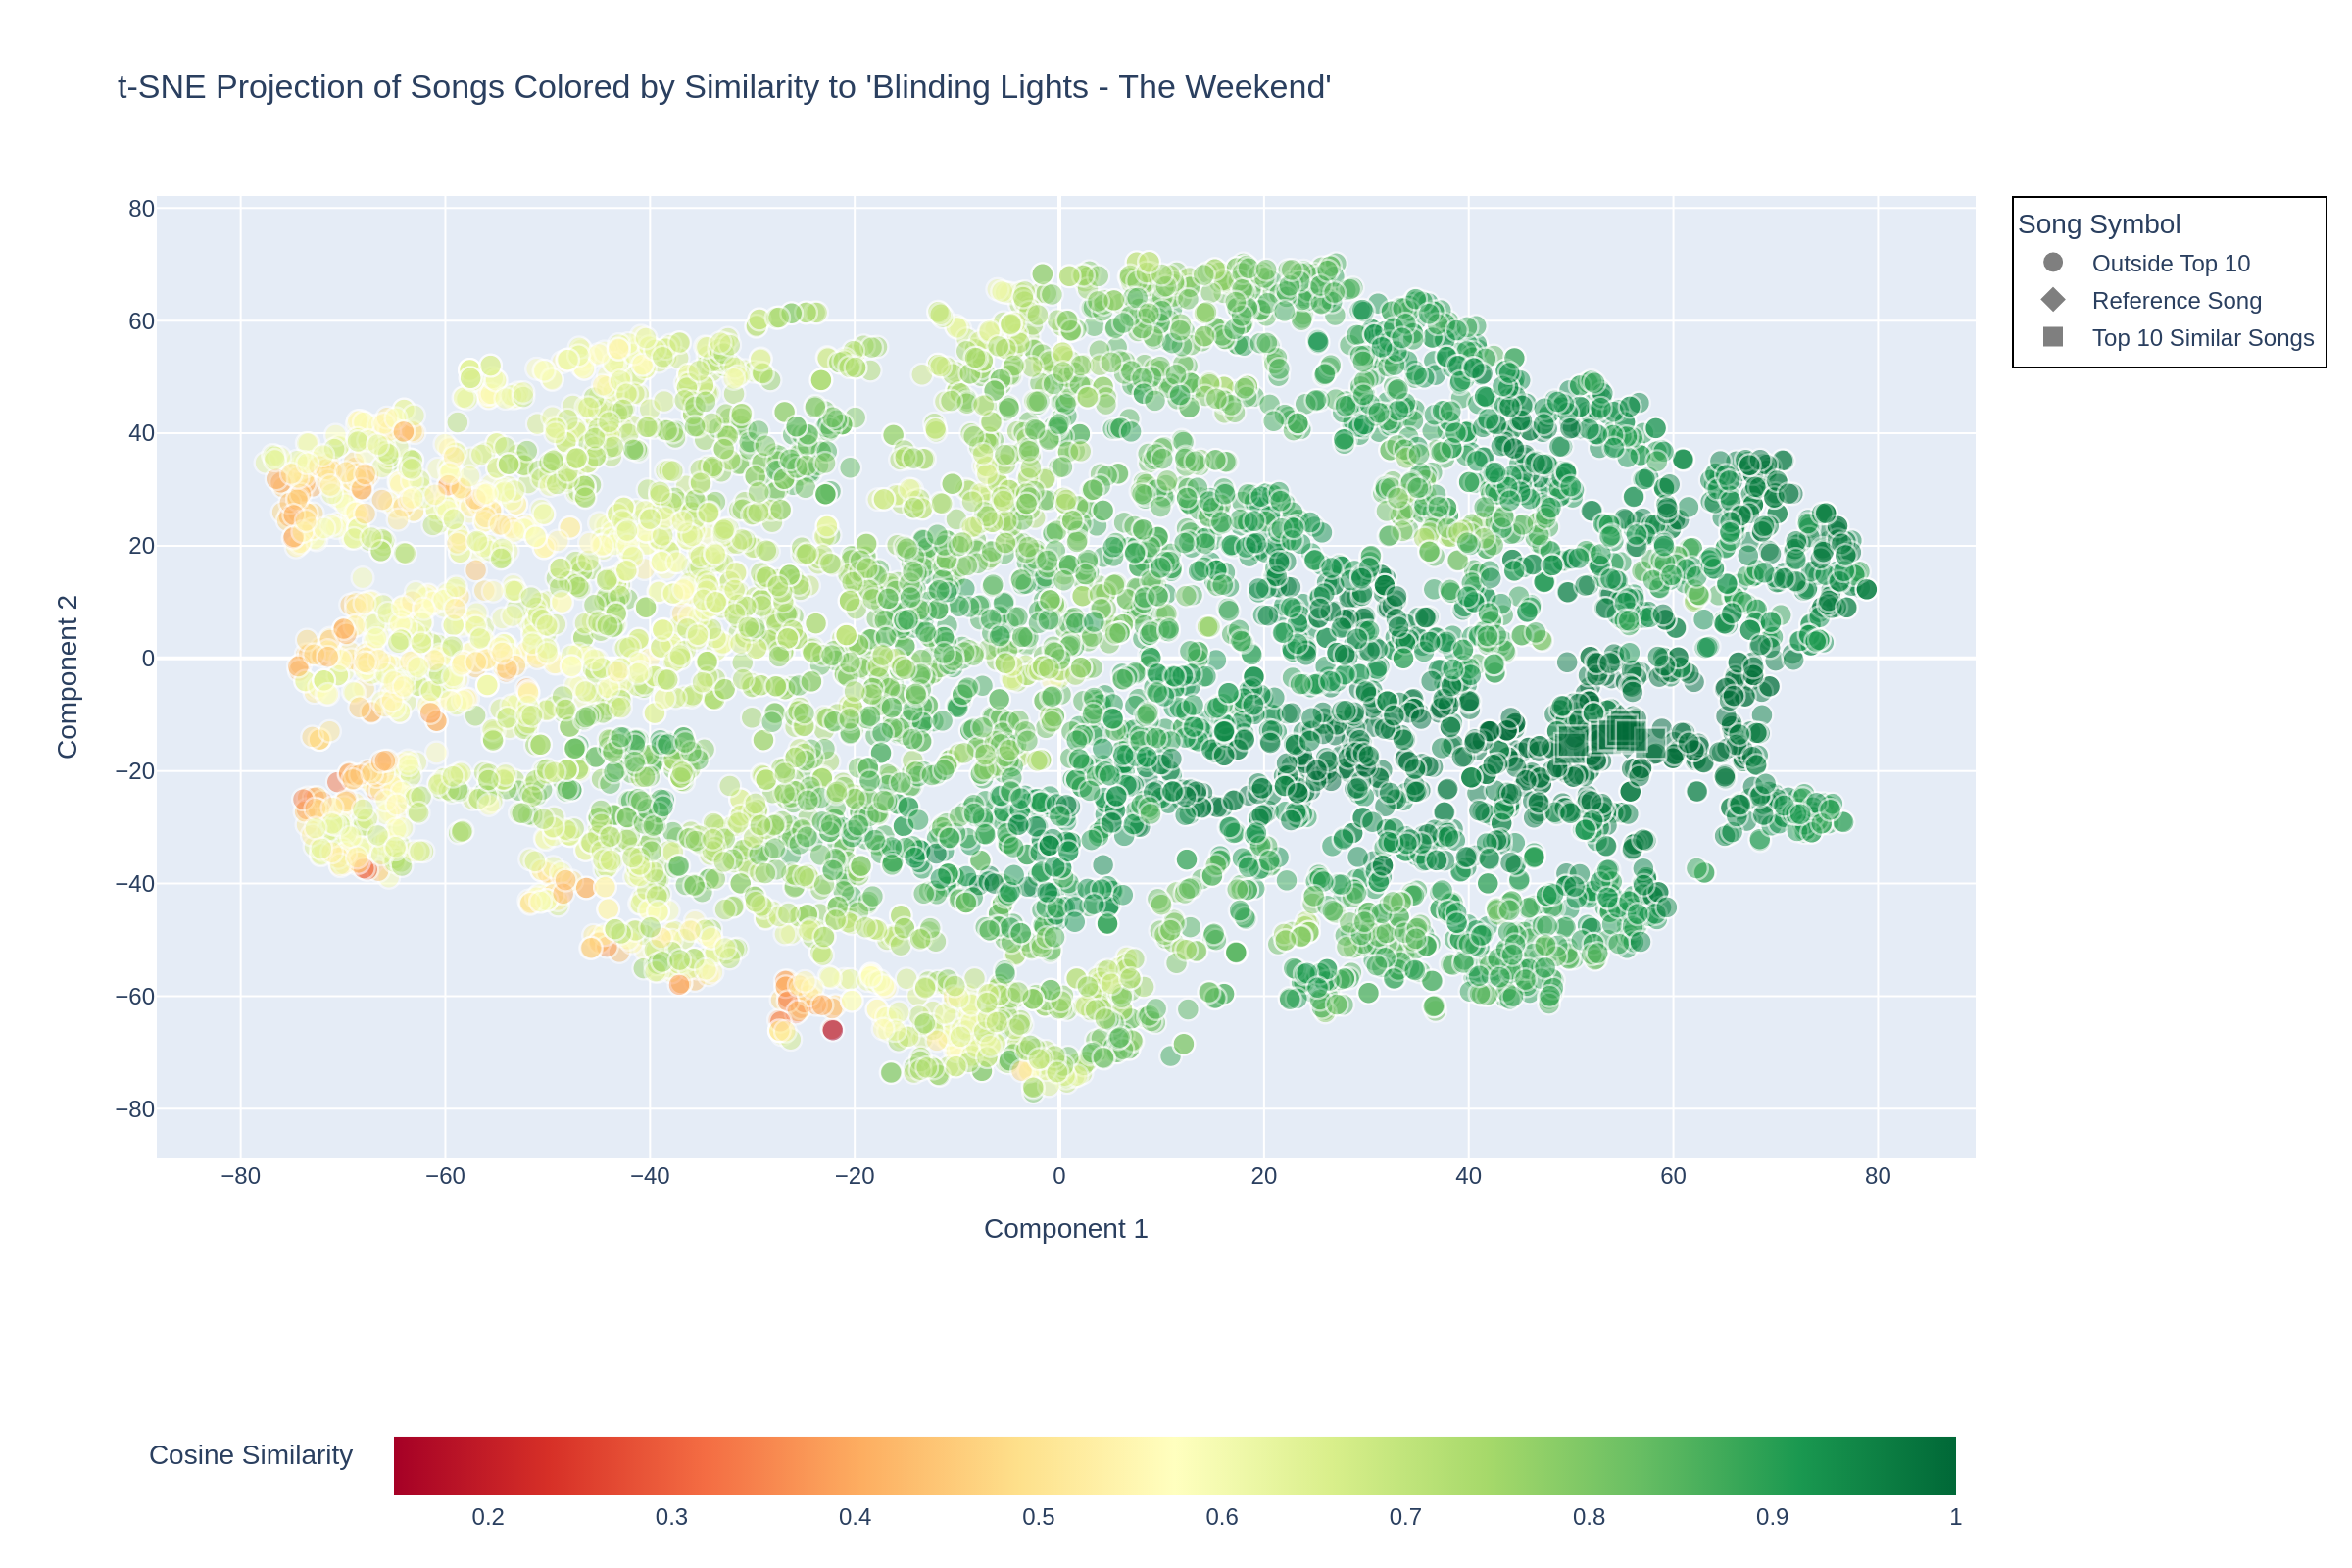

In [15]:
display(Image(filename="tSNE_BlindingLights.png"))

#### Analysis of t-SNE Visualization

The t-SNE plot provides a 2D representation of the high-dimensional song feature space, allowing visual inspection of how songs relate to the reference track, *Blinding Lights – The Weeknd*.

Key observations:

- The **reference track** is clearly marked with a distinct symbol, surrounded closely by its **top 10 most similar songs**, indicating strong local similarity.
- These top recommendations form a **tight cluster**, supporting the effectiveness of the NMF-based representation and cosine similarity for capturing musical resemblance.
- Tracks that are **less similar** are distributed farther away and transition gradually in color from green (high similarity) to red (low similarity), reflecting the continuous similarity spectrum.
- The **overall distribution** suggests several natural groupings or musical clusters, which may correspond to genre, tempo, or mood similarities beyond the scope of individual features.

> ✅ The visualization serves as an intuitive, interpretable validation of the similarity engine and highlights the potential for expanding this method to interactive recommendation systems.

### Conclusion

This project demonstrates how machine learning and audio feature engineering can be combined to uncover hidden relationships between songs. By leveraging:

- **Unsupervised learning techniques** (NMF and t-SNE),
- **Content-based similarity** via cosine distance,
- And **interactive visualizations** through Plotly,

the system recommends tracks that share a similar musical profile, enabling discovery beyond charts or user behavior.

This methodology serves as a foundation for building more advanced music recommendation systems, including:

- **Hybrid recommenders** (combining content and collaborative signals),
- **Neural embeddings** for capturing deep semantic audio properties,
- Or **real-time playlist generation** based on mood, genre, or latent feature clusters.

> 🎧 This approach illustrates how data-driven methods can enhance personalized music experiences by focusing on sound, structure, and feel rather than popularity alone.

### References

- [Spotify Top Songs & Audio Features Dataset](https://www.kaggle.com/datasets/julianoorlandi/spotify-top-songs-and-audio-features)
- [t-SNE Explained (Distill.pub)](https://distill.pub/2016/misread-tsne/)
- [Scikit-learn Documentation](https://scikit-learn.org/stable/)
- [Plotly Express Documentation](https://plotly.com/python/plotly-express/)

---